In [1]:
from datasets import load_dataset
dataset = load_dataset("tau/commonsense_qa")


In [2]:
dataset["train"][1]

{'id': '61fe6e879ff18686d7552425a36344c8',
 'question': 'Sammy wanted to go to where the people were.  Where might he go?',
 'question_concept': 'people',
 'choices': {'label': ['A', 'B', 'C', 'D', 'E'],
  'text': ['race track',
   'populated areas',
   'the desert',
   'apartment',
   'roadblock']},
 'answerKey': 'B'}

In [3]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
base_model = "NousResearch/Llama-2-7b-chat-hf"
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/chowder/.local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/chowder/.local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/chowder/.local/lib/python3.8/site-packages/transform

In [4]:
tokenizer.tokenize("Sammy wanted to go to where the people were.  Where might he go?")

['▁Sam',
 'my',
 '▁wanted',
 '▁to',
 '▁go',
 '▁to',
 '▁where',
 '▁the',
 '▁people',
 '▁were',
 '.',
 '▁',
 '▁Where',
 '▁might',
 '▁he',
 '▁go',
 '?']

In [5]:
tokenizedQuestionLengths = []
for q in dataset["train"]:
    tokenizedQuestionLengths.append(len(tokenizer.tokenize(q["question"])))
print(max(tokenizedQuestionLengths))

76


(0.0, 720.0)

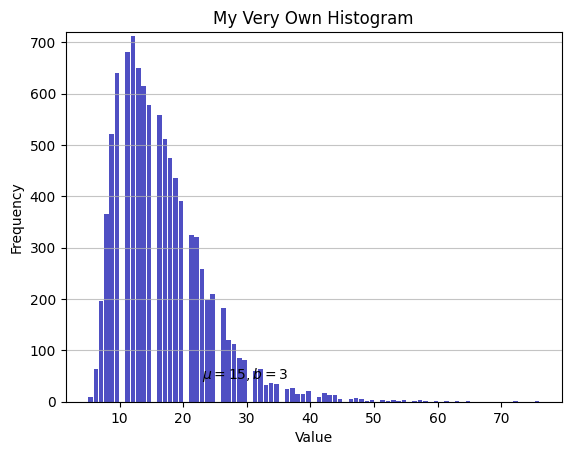

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=tokenizedQuestionLengths, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Token Lengths of questions ')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [12]:
tALenghts = []
for q in dataset["train"]:
    for answerOption in q["choices"]["text"]:
        tALenghts.append(len(tokenizer.tokenize(answerOption)))
print(max(tALenghts))

34


(0.0, 20950.0)

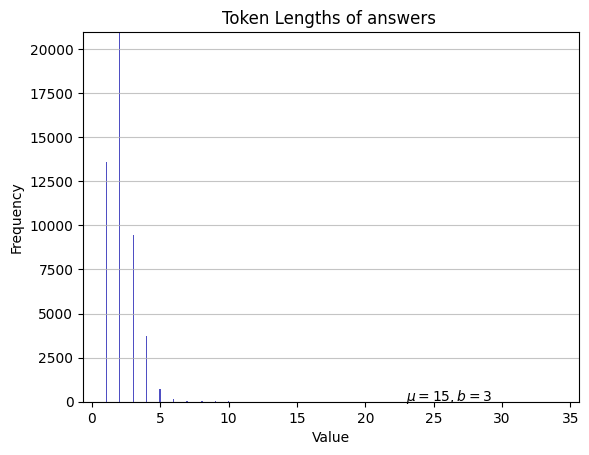

In [13]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=tALenghts, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Token Lengths of answers ')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
#I feel like the strategy of determining the log probabilites of each of the answer types for completion wouldn't be so easy
#because of the varying lengths of the answers

#but the prompting sounds tough too
#maybe something like this <question> please choose from A
#respond with the letter of the correct answer. Sammy wanted to go to where the people were.  Where might he go? A) race track B) populated areas C) the desert D) apartment E) roadblock
 
#'race track',
   'populated areas',
   'the desert',
   'apartment',
   'roadblock'
